# Telco 고객 이탈 분석 프로젝트 정리

### 프로젝트 개요
목표: 고객 이탈 여부(Churn)를 예측하여, 이탈 가능성이 높은 고객을 사전에 식별하고 마케팅 및 고객 유지 전략 수립에 활용한다. 이탈 고객이 발생하면 직접적인 매출 손실로 이어지기 때문에 예측하고 예방하고자 함이다. 

목적
- Telco 산업은 정기적인 구독 기반(월 정액) 모델이 많아 고객이 떠나면 매출이 하락한다.
- 기존 고객을 유지하는 것이 신규 고객을 확보하는 비용보다 약 5~7배 저렴하다.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## 1. 데이터 불러오기 및 구조 확인 

In [3]:
df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## 2. 데이터 정제 및 전처리
### 2-1. TotalCharges 문자열 → 수치형 변환

In [7]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
df.dropna(inplace=True)
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### 2-2. 타겟 변수 이진화 (Churn: Yes → 1, No → 0)

In [9]:
binary_cols = ['Churn', 'PaperlessBilling']
for col in binary_cols:
    df[col] = df[col].map({'No': 0, 'Yes': 1})

### 2-3. 불필요한 컬럼 제거 (고유 ID 제외)

In [10]:
df.drop(columns=['customerID'], inplace=True)

## 3. 범주형 변수 인코딩
### 3-1. 범주형 변수 자동 탐색

In [11]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()

### 3-2. One-hot Encoding 수행 (drop_first=True 적용)

In [12]:
categorical_cols = [
    'gender', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
]
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_encoded.head()

,SeniorCitizen,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,1,29.85,29.85,0,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,0,34,0,56.95,1889.50,0,True,False,False,True,...,False,False,False,False,False,True,False,False,False,True
2,0,2,1,53.85,108.15,1,True,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3,0,45,0,42.30,1840.75,0,True,False,False,False,...,True,False,False,False,False,True,False,False,False,False
4,0,2,1,70.70,151.65,1,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False


drop_first=False: 모든 카테고리에 대해 새로운 열을 생성합니다. (때로는 drop_first=True를 사용하여 다중 공선성을 피하기도 하지만, 모델에 따라 성능 차이가 미미할 수 있습니다.)

In [13]:
# 모든 bool 타입 컬럼을 0/1로 변환
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

df_encoded.head()

,SeniorCitizen,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,1,29.85,29.85,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,34,0,56.95,1889.50,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
2,0,2,1,53.85,108.15,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,45,0,42.30,1840.75,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,2,1,70.70,151.65,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


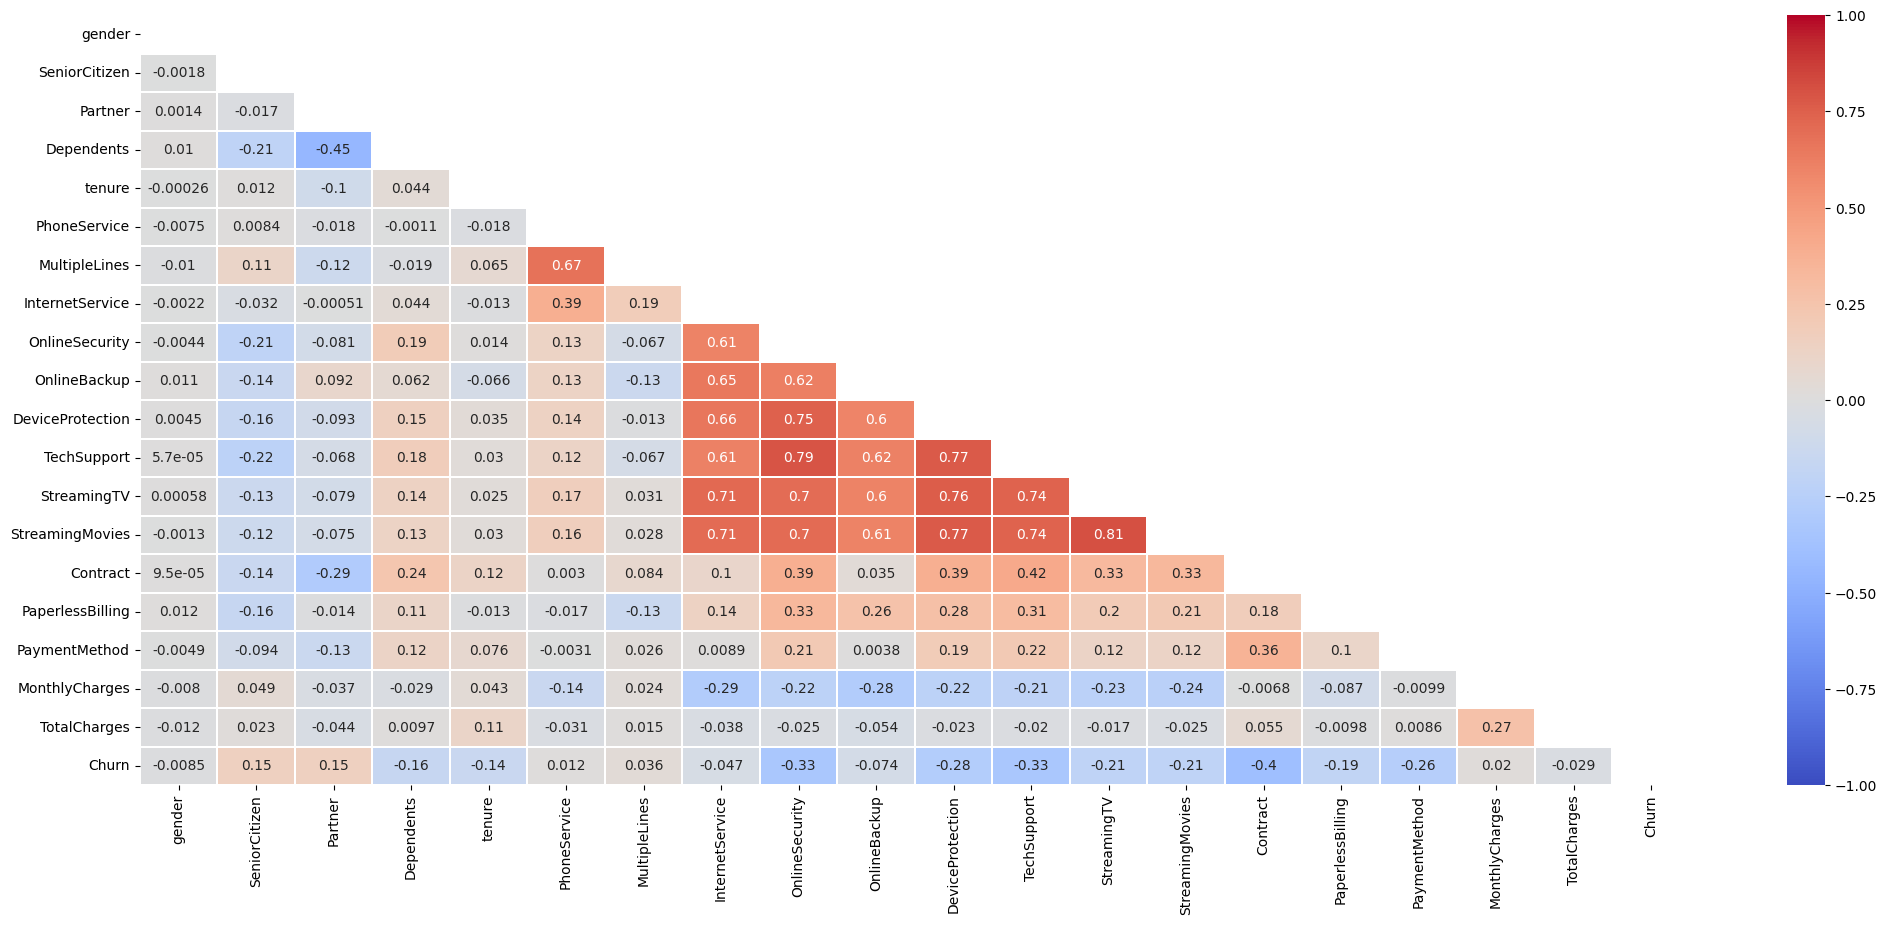

In [14]:
plt.figure(figsize=(25, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

## 4. 결과 확인
데이터 전처리 완료 후 shape 및 주요 컬럼 확인

In [15]:
print("변환 후 shape:", df_encoded.shape)
print("컬럼 샘플:", df_encoded.columns[:10])
df_encoded.head()

변환 후 shape: (7032, 31)
컬럼 샘플: Index(['SeniorCitizen', 'tenure', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'gender_Male', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes'],
      dtype='object')


,SeniorCitizen,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,1,29.85,29.85,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,34,0,56.95,1889.50,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
2,0,2,1,53.85,108.15,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,45,0,42.30,1840.75,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,2,1,70.70,151.65,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 5. 고객 이탈 예측 모델 만들기 (Logistic Regression & Random Forest)
### 5-1 타겟 분리

In [16]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

### 5-2 학습/테스트 분할

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

log_reg = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

### 5-3 모델 학습 (Logistic Regression, Random Forest)

In [18]:
log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 5-4 예측 및 평가 지표 출력 

In [19]:
y_pred_log = log_reg.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(name, y_test, y_pred):
    print(f"\n{name} 성능평가")
    print("Accuracy :", round(accuracy_score(y_test, y_pred), 3))
    print("Recall   :", round(recall_score(y_test, y_pred), 3))
    print("F1 Score :", round(f1_score(y_test, y_pred), 3))

evaluate_model("Logistic Regression", y_test, y_pred_log)
evaluate_model("Random Forest", y_test, y_pred_rf)


Logistic Regression 성능평가
Accuracy : 0.799
Recall   : 0.567
F1 Score : 0.6

Random Forest 성능평가
Accuracy : 0.794
Recall   : 0.511
F1 Score : 0.568


## 6. 시각화

<Axes: xlabel='PaymentMethod', ylabel='count'>

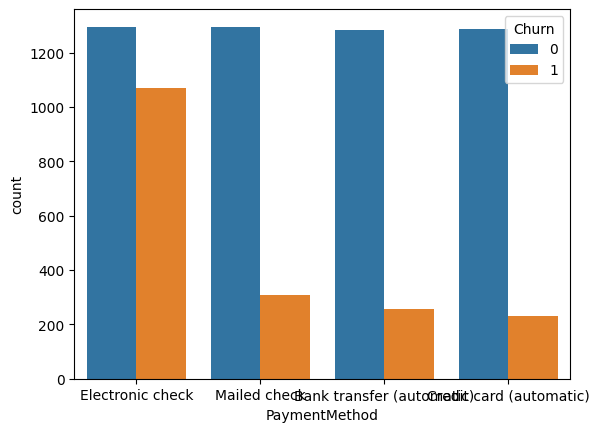

In [20]:
sns.countplot(x='PaymentMethod', hue='Churn', data=df)

🔍 관찰 결과:
전자 수표(Electronic check) 사용자의 이탈률이 유독 높았어.

📌 왜 중요한가?
전자 수표는 납부가 번거롭거나 실패 위험이 상대적으로 큼

자동이체나 신용카드 자동 결제 고객은 이탈률이 낮음
→ 서비스 이용 지속성이 높을 수 있음

🎯 결론:
결제 방식 자체가 “고객과의 관계 밀도”를 나타내는 신호일 수 있음
→ 전자 수표 사용자에게 결제 수단 변경 유도 or 리마인드 캠페인 필요

<Axes: xlabel='tenure', ylabel='Count'>

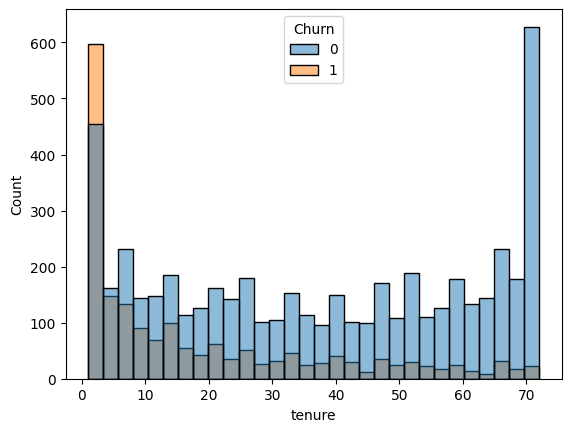

In [21]:
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=False)

🔍 관찰 결과:
tenure가 짧은 고객일수록 이탈 비율이 높음 (왼쪽 구간에 이탈자 밀집)

📌 왜 중요한가?
신규 고객은 아직 서비스에 대한 충성도가 낮음

3개월 이내 해지 비율이 가장 높았음

🎯 결론:
신규 가입 초기 3개월 고객 = 최대 이탈 위험군
→ 웰컴 케어, 전담 매니저, 혜택 안내 등 집중 케어 필요



고객 이탈의 주요 원인 
1. 계약 유형 (Contract Type): 월별 계약(Month-to-month contract)을 맺은 고객의 이탈률이 훨씬 높습니다. 1년 또는 2년 장기 계약 고객은 이탈률이 현저히 낮습니다. 이는 장기 계약이 고객 충성도와 이탈 방지에 매우 효과적임을 시사합니다.
2. 인터넷 서비스 (Internet Service): 특히 광섬유(Fiber Optic) 인터넷 서비스를 사용하는 고객들의 이탈률이 높게 나타납니다. 이는 광섬유 서비스의 품질 문제, 경쟁사의 더 나은 제안, 또는 서비스 만족도 저하 등 복합적인 원인이 있을 수 있습니다. 반면, 인터넷 서비스를 사용하지 않는 고객의 이탈률은 매우 낮습니다.
3. 결제 방식 (Payment Method): **전자 수표(Electronic Check)**를 사용하는 고객의 이탈률이 높습니다. 이는 결제 과정의 불편함이나 보안 문제 등과 관련이 있을 수 있습니다.
4. 월별 요금 (Monthly Charges) 및 총 요금 (Total Charges): 월별 요금이 높은 고객일수록 이탈률이 다소 높은 경향을 보입니다. 또한, 총 요금이 낮고 계약 기간이 짧은 고객(특히 초기 몇 개월)의 이탈률이 높습니다. 이는 신규 고객 확보 후 초기 이탈 방지가 중요함을 의미합니다.
5. 기술 지원 (Tech Support) 및 온라인 보안 (Online Security): 기술 지원이나 온라인 보안 등 부가 서비스를 구독하지 않은 고객의 이탈률이 높습니다. 이러한 부가 서비스는 고객 만족도를 높이고 이탈을 줄이는 데 기여하는 것으로 보입니다.

제안 
1. 장기 계약 유도: 월별 계약 고객에게 장기 계약으로 전환 시 인센티브를 제공하여 이탈을 줄입니다.
2. 초기 고객 관리 강화: 신규 가입 고객의 서비스 이용 초기(첫 6개월)에 대한 집중적인 관리가 필요하다. 잠재적인 불편 사항을 선제적으로 파악하여 해결해야 한다.
3. 결제 방식 개선: 전자수표 외의 결제 방식 사용을 장려하고, 전자 수표 결제의 편의성을 검토하여 개선한다.
4. 이탈 위험 고객 예측 시스템 구축: 예측 모델을 활용하여 이탈 위험이 높은 고객을 사전에 식별하고, 개인화된 할인, 쿠폰, 상담을 통해 이탈을 방지하는 proactive한 접근 방식을 도입한다. 